In [1]:
import pandas as pd
from vllm import LLM, SamplingParams
import os
from vllm.sampling_params import GuidedDecodingParams

import ctypes
import os

# Ensure CUDA runtime is available
cuda_lib_path = "/opt/cuda/cuda-11.7/targets/x86_64-linux/lib/libcudart.so.11.0"
ctypes.CDLL(cuda_lib_path)

# Optional: set environment variable
os.environ["LD_LIBRARY_PATH"] = f"{os.path.dirname(cuda_lib_path)}:" + os.environ.get("LD_LIBRARY_PATH", "")

# Load the dataset
df = pd.read_csv("../idiom_data/idiom_dataset_en.csv")
df = df.dropna(subset=["id", "idiom", "idiom_sentence", "original_idiom_sentence", "good_paraphrase"])

# Initialize your LLaMA model
llm = LLM(
    model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    max_model_len=4096,
    gpu_memory_utilization=0.95
)


/cs/student/projects1/dsml/2024/eborso/project_venv/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-04-07 12:06:11.440824: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 12:06:11.449094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744023971.458651  406569 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744023971.461484  406569 cuda_blas.cc:1407] Unable to reg

INFO 04-07 12:06:13 [__init__.py:239] Automatically detected platform cuda.
INFO 04-07 12:06:25 [config.py:585] This model supports multiple tasks: {'generate', 'classify', 'reward', 'score', 'embed'}. Defaulting to 'generate'.
INFO 04-07 12:06:25 [config.py:1697] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 04-07 12:06:26 [core.py:54] Initializing a V1 LLM engine (v0.8.2) with config: model='meta-llama/Meta-Llama-3.1-8B-Instruct', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3.1-8B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar', reasoning_backen

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 04-07 12:06:31 [loader.py:447] Loading weights took 2.12 seconds
INFO 04-07 12:06:31 [gpu_model_runner.py:1186] Model loading took 14.9889 GB and 3.524831 seconds
INFO 04-07 12:06:36 [backends.py:415] Using cache directory: /cs/student/projects1/dsml/2024/eborso/project_venv/.cache/vllm/torch_compile_cache/0567c090ac/rank_0_0 for vLLM's torch.compile
INFO 04-07 12:06:36 [backends.py:425] Dynamo bytecode transform time: 4.68 s
INFO 04-07 12:06:36 [backends.py:115] Directly load the compiled graph for shape None from the cache
INFO 04-07 12:06:40 [monitor.py:33] torch.compile takes 4.68 s in total
INFO 04-07 12:06:42 [kv_cache_utils.py:566] GPU KV cache size: 12,208 tokens
INFO 04-07 12:06:42 [kv_cache_utils.py:569] Maximum concurrency for 4,096 tokens per request: 2.98x
INFO 04-07 12:07:04 [gpu_model_runner.py:1534] Graph capturing finished in 22 secs, took 0.51 GiB
INFO 04-07 12:07:04 [core.py:151] init engine (profile, create kv cache, warmup model) took 32.82 seconds


In [15]:

json_schema = {
    "type": "object",
    "properties": {
        "example1": {"type": "string"},
        "example2": {"type": "string"},
    },
    "required": ["example1","example2"]
}

guided_decoding_params = GuidedDecodingParams(json=json_schema)


sampling_params = SamplingParams(
        temperature=0.5,
        max_tokens=1024,
        stop=["<|eot_id|>"],
        guided_decoding=guided_decoding_params
    )

In [16]:
def build_prompt(idiom, idiom_sentence, paraphrase):
    return f"""You are a figurative language assistant.

Below is an idiomatic sentence and its plain English paraphrase. Your task is to create **two new original sentences** using the idiom "{idiom}", each in a different context.

---
Idiomatic sentence (example): {idiom_sentence}
Plain English paraphrase: {paraphrase}

Now generate two new sentences using the idiom "{idiom}".
Only output the two new sentences using the format shown below, WITHOUT ADDING ANYTHING ELSE.
Format:
Your response must be a valid JSON object with two fields:
    1. 'example1' (the first generated sentence with the idiom)
    2. 'example2' (the second generated sentence with the idiom)
"""


In [ ]:
from tqdm import tqdm
import json

# Batch size
BATCH_SIZE = 32
results = []

for i in tqdm(range(0, len(df), BATCH_SIZE)):
    batch = df.iloc[i:i + BATCH_SIZE]

    # Create chat-style prompts using the guided JSON schema
    conversations = [
        [{"role": "user", "content": build_prompt(row["idiom"], row["idiom_sentence"], row["good_paraphrase"])}]
        for _, row in batch.iterrows()
    ]

    # Generate outputs in batch using guided decoding
    outputs = llm.chat(conversations, sampling_params)

    # Parse and collect results
    for row, output in zip(batch.itertuples(), outputs):
        text = output.outputs[0].text.strip()
        try:
            # Guided decoding ensures valid JSON most of the time
            parsed = json.loads(text)
            example1 = parsed["example1"]
            example2 = parsed["example2"]
        except (json.JSONDecodeError, KeyError) as e:
            print(f"[⚠️] Failed to parse or missing field for ID {row.id} — {e}")
            print(f"Raw output:\n{text}\n")
            example1, example2 = "", ""

        results.append({
            "id": row.id,
            "idiom": row.idiom,
            "idiom_sentence": row.idiom_sentence,
            "original_idiom_sentence": row.original_idiom_sentence,
            "good_paraphrase": row.good_paraphrase,
            "example1": example1,
            "example2": example2
        })


In [6]:
import pandas as pd
output_df = pd.DataFrame(results)
output_df.to_csv("idiom_examples_batched.csv", index=False)
print("Saved to generated/idiom_examples_batched.csv")


Saved to generated/idiom_examples_batched.csv


In [2]:
output_df = pd.read_csv("idiom_examples_batched.csv")

In [3]:
def clean_quotes(text):
    return (
        text.replace('"', "'")
            .replace("''", "'")
            .replace("“", "'")
            .replace("”", "'")
    )


def build_paraphrase_prompt(idiom, original_sentence, example1, example2):
    original_sentence = clean_quotes(original_sentence)
    example1 = clean_quotes(example1)
    example2 = clean_quotes(example2)
    ...

    return f"""You are a figurative language assistant.

Below are three sentences that all contain the same idiom {idiom}. Only the first sentence must be translated into plain English. The other two are provided as context to show how the idiom can appear in different situations — do not include or refer to them in your output.

Your task is to rewrite **only Sentence 1** by replacing the idiom with its literal meaning, while preserving the overall meaning of the sentence.

Your output must be a **valid JSON object** with exactly one field:
- "sentence1_translation": (the translated sentence)

Do not include explanations, labels, or anything else — only return the JSON object.

Example:

Sentence 1 (to translate): He IDkicked the bucketID last night.
Sentence 2 (example): She IDkicked the bucketID after a long illness.
Sentence 3 (example): The soldier IDkicked the bucketID on the battlefield.

Output:
{{"sentence1_translation": "He died last night."}}

Now translate:

Sentence 1 (to translate): {original_sentence}
Sentence 2 (example): {example1}
Sentence 3 (example): {example2}

Your output must be a **valid JSON object** with exactly one field:
- "sentence1_translation": (the translated sentence):

Important: If your translation contains quotation marks, replace them with ' so the output remains valid JSON."""

In [4]:
import re
import json

def extract_json_field(raw_text, key="sentence1_translation"):
    """
    Extract the first valid JSON object and safely handle unescaped quotes inside string values.
    """
    # Match all {...} blocks in the output
    json_candidates = re.findall(r'\{.*?\}', raw_text, re.DOTALL)

    for candidate in json_candidates:
        try:
            # First, try parsing it directly
            return json.loads(candidate)[key].strip()
        except json.JSONDecodeError:
            # Try sanitizing problematic quote patterns
            # e.g., inside a JSON string, replace:  ,"  or  : "Some "quoted" thing"
            safe_candidate = candidate

            # Escape any unescaped inner quotes inside string values
            # (conservative version – won't overcorrect)
            safe_candidate = re.sub(
                r'(?<=:\s")([^"]*?)(?<!\\)"(?!\s*[,}])',  # find bad quotes inside strings
                lambda m: m.group(0).replace('"', '\\"'),
                safe_candidate
            )

            try:
                return json.loads(safe_candidate)[key].strip()
            except json.JSONDecodeError as e:
                continue  # try next candidate

    return ""


In [14]:
json_schema = {
    "type": "object",
    "properties": {
        "sentence1_translation": {"type": "string"},
    },
    "required": ["sentence1_translation"]
}

guided_decoding_params = GuidedDecodingParams(json=json_schema)


sampling_params = SamplingParams(
        temperature=0.5,
        max_tokens=1024,
        stop=["<|eot_id|>"],
        guided_decoding=guided_decoding_params
    )

In [5]:
import json
from tqdm import tqdm
from vllm import SamplingParams

BATCH_SIZE = 16
results = []

# Loop through the dataset in batches
for i in tqdm(range(0, len(df), BATCH_SIZE)):
    batch = output_df.iloc[i:i + BATCH_SIZE]

    # Create chat-style input
    conversations = [
        [{"role": "user", "content": build_paraphrase_prompt(row["idiom"], row["idiom_sentence"], row["example1"], row["example2"])}]
        for _, row in batch.iterrows()
    ]

    # Generate in batch
    outputs = llm.chat(conversations, sampling_params)

    for row, output in zip(batch.itertuples(), outputs):
        raw_output = output.outputs[0].text.strip()

        try:
            #parsed = json.loads(raw_output)
            translated = extract_json_field(raw_output)
        except json.JSONDecodeError as e:
            print(f"[⚠️] JSON decode error for ID {row.id}: {e}")
            print(raw_output)
            translated = ""

        results.append({
            "id": row.id,
            "idiom": row.idiom,
            "original_sentence": row.idiom_sentence,
            "translated_sentence": translated,
            "example1": row.example1,
            "example2": row.example2
        })

  0%|          | 0/169 [00:00<?, ?it/s]

INFO 04-07 12:07:26 [chat_utils.py:379] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


100%|██████████| 169/169 [06:41<00:00,  2.38s/it]


/cs/student/projects1/dsml/2024/eborso/project_venv/lib/python3.10/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [6]:
output_df2 = pd.DataFrame(results)
output_df2.to_csv("idiom_translation_from_examples.csv", index=False)
print("Saved to idiom_translation_from_examples.csv")


Saved to idiom_translation_from_examples.csv


In [7]:
import os
import pandas as pd
import json
from sacrebleu.metrics import CHRF

LLM_VERSION = "RAG_examples"
RESULTS_FILE = f"chrF_scores_{LLM_VERSION}"

import os

# Get current working directory in a notebook
script_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(script_dir, '..'))
data_file = os.path.join(project_root, 'utils', f'idiom_translation_from_examples.csv')

output_dir = os.path.join(project_root, 'metrics', 'chrf++', 'outputs')
os.makedirs(output_dir, exist_ok=True)
df = pd.read_csv(data_file)

chrf = CHRF()
results = []
count = 0
id_val = 0
for idx, row in df.iterrows():
    hypothesis = row['translated_sentence']
    reference = row['original_sentence']
    

    if isinstance(hypothesis, str) and isinstance(reference, str):
        score = chrf.sentence_score(hypothesis, [reference]).score
        results.append({'id': id_val, 'score': score})
    else:
        print(f"[⚠️] Skipping ID {row['id']} due to invalid type")
        print(f"{row['id']} hypothesis(translation) is a string: {isinstance(hypothesis, str)}")
        print(f"{row['id']} reference(original) is a string: {isinstance(reference, str)}")
        count +=1

    
    id_val += 1

results_df = pd.DataFrame(results)

csv_output_path = os.path.join(output_dir, f"{RESULTS_FILE}.csv")
results_df.to_csv(csv_output_path, index=False)

json_output_path = os.path.join(output_dir, f"{RESULTS_FILE}.json")
with open(json_output_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

print("Scores have been saved to:")
print(f" - CSV: {csv_output_path}")
print(f" - JSON: {json_output_path}")

[⚠️] Skipping ID 10456 due to invalid type
10456 hypothesis(translation) is a string: False
10456 reference(original) is a string: True
[⚠️] Skipping ID 10614 due to invalid type
10614 hypothesis(translation) is a string: False
10614 reference(original) is a string: True
[⚠️] Skipping ID 10627 due to invalid type
10627 hypothesis(translation) is a string: False
10627 reference(original) is a string: True
[⚠️] Skipping ID 10687 due to invalid type
10687 hypothesis(translation) is a string: False
10687 reference(original) is a string: True
[⚠️] Skipping ID 10733 due to invalid type
10733 hypothesis(translation) is a string: False
10733 reference(original) is a string: True
[⚠️] Skipping ID 10871 due to invalid type
10871 hypothesis(translation) is a string: False
10871 reference(original) is a string: True
[⚠️] Skipping ID 10975 due to invalid type
10975 hypothesis(translation) is a string: False
10975 reference(original) is a string: True
[⚠️] Skipping ID 101194 due to invalid type
1011

In [8]:
count

18

In [12]:
output_df2.iloc[1]["example1"]

"The city's rapid growth was attributed to a high birthrate, which led to an influx of new businesses and services catering to young families."

In [12]:
import pandas as pd

# Load both CSV files
df_rag = pd.read_csv("../metrics/chrf++/outputs/chrF_scores_RAG_examples.csv")
df_base = pd.read_csv("../metrics/chrf++/outputs/chrF_scores_Meta-Llama-3.1-8B-Instruct_20250317_151054.csv")

# Compute basic statistics
rag_stats = {
    "mean": df_rag["score"].mean(),
    "std": df_rag["score"].std(),
    "min": df_rag["score"].min(),
    "max": df_rag["score"].max()
}

base_stats = {
    "mean": df_base["score"].mean(),
    "std": df_base["score"].std(),
    "min": df_base["score"].min(),
    "max": df_base["score"].max()
}

# Combine into one DataFrame for comparison
stats_df = pd.DataFrame([rag_stats, base_stats], index=["RAG", "Base"])
display(stats_df)


mean        std        min    max
RAG   84.861567  11.284547  10.082265  100.0
Base  80.848783  12.256067  16.216695  100.0

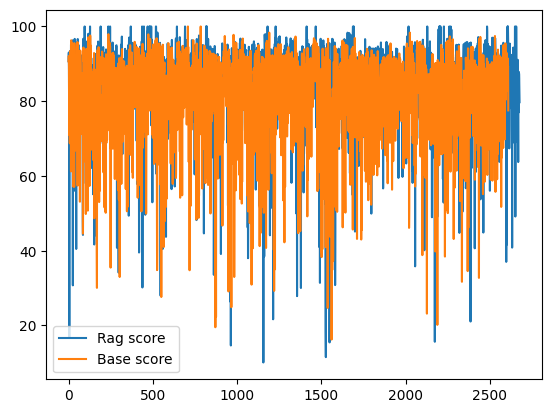

In [13]:
import matplotlib.pyplot as plt
plt.plot(df_rag["score"],label="Rag score")
plt.plot(df_base["score"],label="Base score")
plt.legend()
plt.show()

In [4]:
import os
import pandas as pd
import json
import torch
from comet import download_model, load_from_checkpoint

LLM_VERSION = "RAG_examples"
RESULTS_FILE = f"comet_scores_{LLM_VERSION}"

# Get current working directory in a notebook
script_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(script_dir, '..'))
data_file = os.path.join(project_root, 'utils', f'idiom_translation_from_examples.csv')

output_dir = os.path.join(project_root, 'metrics', 'comet', 'outputs')
os.makedirs(output_dir, exist_ok=True)
df = pd.read_csv(data_file)

model_path = download_model("Unbabel/wmt22-comet-da")
comet = load_from_checkpoint(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
comet.to(device)
results = []

id_val = 0
for _, row in df.iterrows():
    # id_val = row['id']
    reference = row['original_sentence']
    hypothesis = row['translated_sentence']

    data = [{
        "src": "",  # Source sentence is not used in this case
        "mt": hypothesis,
        "ref": reference
    }]

    scores = comet.predict(data)
    score = scores["scores"][0]
    results.append({'id': id_val, 'score': score})
    id_val += 1

results_df = pd.DataFrame(results)

csv_output_path = os.path.join(output_dir, f"{RESULTS_FILE}.csv")
results_df.to_csv(csv_output_path, index=False)

json_output_path = os.path.join(output_dir, f"{RESULTS_FILE}.json")
with open(json_output_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

print("Scores have been saved to:")
print(f" - CSV: {csv_output_path}")
print(f" - JSON: {json_output_path}")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model.ckpt:  89%|########8 | 2.06G/2.32G [00:00<?, ?B/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../project_venv/.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/2760a223ac957f30acfb18c8aa649b01cf1d75f2/checkpoints/model.ckpt`


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Encoder model frozen.
/cs/student/projects1/dsml/2024/eborso/project_venv/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:25<00:00, 25.37s/it]
Traceback (most r

Scores have been saved to:
 - CSV: /cs/student/projects1/dsml/2024/eborso/github_repos/comp0087/metrics/comet/outputs/comet_scores_RAG_examples.csv
 - JSON: /cs/student/projects1/dsml/2024/eborso/github_repos/comp0087/metrics/comet/outputs/comet_scores_RAG_examples.json


In [6]:
import pandas as pd

# Load both CSV files
df_rag = pd.read_csv("../metrics/comet/outputs/comet_scores_RAG_examples.csv")
df_base = pd.read_csv("../metrics/comet/outputs/comet_scores_Meta-Llama-3.1-8B-Instruct_20250317_151054.csv")

# Compute basic statistics
rag_stats = {
    "mean": df_rag["score"].mean(),
    "std": df_rag["score"].std(),
    "min": df_rag["score"].min(),
    "max": df_rag["score"].max()
}

base_stats = {
    "mean": df_base["score"].mean(),
    "std": df_base["score"].std(),
    "min": df_base["score"].min(),
    "max": df_base["score"].max()
}

# Combine into one DataFrame for comparison
stats_df = pd.DataFrame([rag_stats, base_stats], index=["RAG", "Base"])
display(stats_df)


mean       std       min       max
RAG   0.817314  0.070918  0.238355  0.927235
Base  0.804143  0.056833  0.478552  0.946461

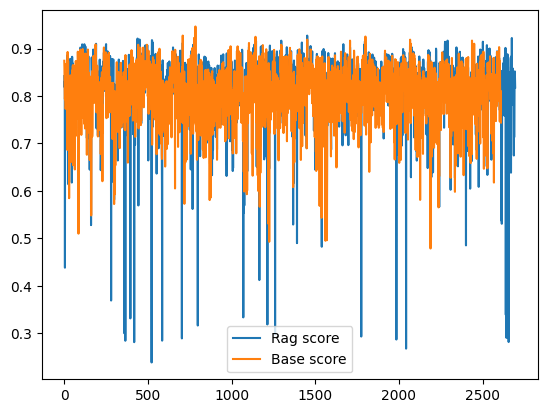

In [7]:
import matplotlib.pyplot as plt
plt.plot(df_rag["score"],label="Rag score")
plt.plot(df_base["score"],label="Base score")
plt.legend()
plt.show()

In [8]:
df = pd.read_csv("idiom_examples_batched.csv")
df


id          idiom  \
0        101       highlife   
1        102      birthrate   
2        103        homerun   
3        105  publicservice   
4        107       swansong   
...      ...            ...   
2691  104474   peckingorder   
2692  104476   peckingorder   
2693  104478   peckingorder   
2694  104480   peckingorder   
2695  104482   peckingorder   

                                         idiom_sentence  \
0     Despite having the riches to afford the highli...   
1     Minister of Family and Social Policy Marlena M...   
2     So Aaron faced the same brutal racism other Bl...   
3     Program leaders said the scholarship defines p...   
4     Blockchains , fundamentally , are banking beca...   
...                                                 ...   
2691  When San Francisco turned the corner to become...   
2692  He saw his playing time diminish as he slid do...   
2693  There 's a peckingorder at this moment in time...   
2694  To keep track of who ’ s who in a complex peck...   
2695  It appears a peckingorder has developed among ...   

                                original_idiom_sentence  \
0     Despite having the riches to afford the IDhigh...   
1     Minister of Family and Social Policy Marlena M...   
2     So Aaron faced the same brutal racism other Bl...   
3     Program leaders said the scholarship defines I...   
4     Blockchains , fundamentally , are banking beca...   
...                                                 ...   
2691  When San Francisco turned the corner to become...   
2692  He saw his playing time diminish as he slid do...   
2693  There 's a IDpeckingorderID at this moment in ...   
2694  To keep track of who ’ s who in a complex IDpe...   
2695  It appears a IDpeckingorderID has developed am...   

                                        good_paraphrase  \
0     Despite having the riches to afford the expens...   
1     Minister of Family and Social Policy Marlena M...   
2     So Aaron faced the same brutal racism other Bl...   
3     Program leaders said the scholarship defines p...   
4     Blockchains , fundamentally , are banking beca...   
...                                                 ...   
2691  When San Francisco turned the corner to become...   
2692  He saw his playing time diminish as he slid do...   
2693  There 's a hiearchical order at this moment in...   
2694  To keep track of who ’ s who in a complex hiea...   
2695  It appears a hiearchical order has developed a...   

                                               example1  \
0     After winning the lottery, Sarah decided to li...   
1     The city's rapid growth was attributed to a hi...   
2     The new marketing strategy hit a home run with...   
3     The new initiative aims to redefine publicserv...   
4     The legendary rockstar took the stage one last...   
...                                                 ...   
2691  After a string of poor performances, the new t...   
2692  The new employee struggled to get ahead in the...   
2693  The new employees were expected to learn the p...   
2694  The new manager struggled to navigate the comp...   
2695  The new employees at the marketing firm soon d...   

                                               example2  
0     The celebrity's publicist struggled to keep he...  
1     The environmental impact of the new developmen...  
2     The innovative solution to the complex problem...  
3     The professor emphasized the importance of pub...  
4     After a long and storied career, the renowned ...  
...                                                 ...  
2691  The company's latest acquisition, a small star...  
2692  As the business expanded, the small startup fo...  
2693  The pecking order in the animal shelter was cl...  
2694  In the animal kingdom, establishing a clear pe...  
2695  After the company reorganized, a clear pecking...  

[2696 rows x 7 columns]